#### 1. Import the Libraries

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorboard
import pandas as pd
import geopandas as gpd
import ee
import geemap
from tqdm import tqdm
import requests
from skimage.io import imread
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from rasterio import plot
import rasterio as rio
import fiona
import folium
from PIL import Image
import numpy as np
import io
import json
import joblib
import pickle
import os
import sys
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

C:\Users\riyad\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


#### 2. Provide necessary inputs

In [3]:
# user input
from_year = 2023
to_year = 2023
from_month = 1
to_month = 12
maximum_cloud = 2                           # cloud cover to filter the images in percentage
max_dark_feature = 1                        # dark feature max percentage to filter the images
aoi_path =  "./Data/Inputs/aoi/extent.shp"   # location of area of interest shape file in your storage
mgrs_tile_no = '48PVT' 

train_samples_path = './Data/Inputs/TrainingTestingData/TrainingData_Reduced.shp'
test_samples_path = './Data/Inputs/TrainingTestingData/TestData_Reduced.shp'
output_path = './Data/Outputs'

#### 3. Authenticate GEE

In [4]:
# #Trigger the authentication flow.
# ee.Authenticate()
# # Initialize the library.
# ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')


GEE_SERVICE_ACC = 'kjr-eej-jahid@ee-kazijahid.iam.gserviceaccount.com'
GEE_CREDS = "D:/3. Projects/dash/ds4rs_main_app/ee-kazijahid-f8bb3244119c.json"
credentials = ee.ServiceAccountCredentials(GEE_SERVICE_ACC, GEE_CREDS)
ee.Initialize(credentials, opt_url='https://earthengine-highvolume.googleapis.com')

#### 4. Defining Necessary functions

In [5]:
# Functions

def getCloudMasks(image):
    scl = image.select('SCL')
    image_cloud_shadow = image.select('SCL').eq([3])
    image_cloud_low = image.select('SCL').eq([7])
    image_cloud_med = image.select('SCL').eq([8])
    image_cloud_high = image.select('SCL').eq([9])
    image_cloud_cirrus = image.select('SCL').eq([10])
    cloud_mask = image_cloud_shadow.add(image_cloud_low).add(image_cloud_med).add(image_cloud_high).add(image_cloud_cirrus)
    invert_cloud_mask = cloud_mask.eq(0).selfMask().rename('NO_CLOUD_MASK') #invert mask will have the pixels with only no cloud
    cloud_mask_only = cloud_mask.eq(1).selfMask().rename('ONLY_CLOUDS_MASK') #this will have only the pixels without cloud
    masks = invert_cloud_mask.addBands(cloud_mask_only)
    return masks



def cloudFIll(image, filler):
    filler = ee.Image(filler).divide(10000)
    image_filled = image.unmask(filler)
    return image_filled


def functn_scale_bands(image, bandstoscale, scalefactor):
    scaledbands = image.select(bandstoscale).multiply(scale_factor)
    return image.addBands(scaledbands, overwrite=True)


def functn_ResemapleSentinel2(img):
    'Function to resample the sentinel bands from there native scale to 10 meter scale. Takes the image as iput, return the resampled image'
    crs =  img.select('B1').projection().crs()
    img = img.resample('bilinear').reproject(crs=crs, scale=10)
    return img


def functn_Clip(img, aoi_ee):
    'Cliping the bands of the image to the area of interest. Takes the image and aoi feature as input and returns the clipped image.'
    clipped_img = img.clip(aoi_ee)
    return clipped_img


def functn_Ndbi(img):
    'Function to calculate ndbi for the provided image. Takes the multiband image as input, and returns a single band image \
    as output. NDBI formula is (B11 -B8)/(B11+B8). collected from https://d-nb.info/1195147821/34'
    ndbi = img.normalizedDifference(['B11', 'B8']).rename('NDBI')  # in sentinel 2  B11 is SWIR and B8 is NIR,
    return ndbi


#NDWI
def functn_Ndwi(img):
    'Calculates the NDWI for. Take the multiband image as input, returns single band NDWI image.\
    NDWI formula NDWI= (Band 3 – Band 8)/(Band 3 + Band 8) is collected from doi:10.1080/01431169608948714'
    ndwi = img.normalizedDifference(['B3', 'B8']).rename('NDWI') # in sentinel 2 b3 is Green and b8 is NIR
    return ndwi


# NDVI
def functn_Ndvi(img):
    'Calculates the NDVI. Takes the multiband image as input and returns single band NDVI image\
    Formula is NDVI = (B8-B4)/(B8+B4) collected from https://www.geo.fu-berlin.de/en/v/geo-it/gee/2-monitoring-ndvi-nbr/2-1-basic-information/index.html'
    ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI') # In Sentinel 2 B8 is NIR and B4 is Red
    return ndvi


# BSI
def functn_Bsi(img):
    'Calculates the Baresoil index. Take the multiband image as input and returns singleband BSI image\
    The formula BSI = ((SWIR2 + RED)−(NIR + BLUE)) / ((SWIR2 + RED)+(NIR + BLUE)). Collected from Land 2021, 10(3), 231; https://doi.org/10.3390/land10030231'
    bsi = img.expression('( ( SWIR2 + RED ) - ( NIR + BLUE ) ) / ( ( SWIR2 + RED ) + ( NIR + BLUE))',
        {'RED': img.select('B4'),
         'SWIR2': img.select('B12'),
         'NIR': img.select('B8'),
         'BLUE': img.select('B2')}).rename('BSI')
    return bsi


# NDSI    (B3-B11)/(B3+B11)   (Green Band - SWIR Band) / (Green Band + SWIR Band)
def functn_Ndsi(img):
    'Calculates the NDSI. Take the multiband image as input, returns single band NDSI image.'
    ndsi = img.normalizedDifference(['B3', 'B11']).rename('NDSI')
    return ndsi


# EVI     2.5 * ((B8 – B4) / (B8 + 6 * B4 – 7.5 * B2 + 1))
def functn_Evi(image):
    coef1 = ee.Number(2.5)
    coef_red = ee.Number(6)
    coef_blue = ee.Number(7.5)
    const = ee.Number(1)
    # compute EVI
    evi = image.expression('coef1*((nir-red)/(nir + (coef_red*red)-(coef_blue*blue) + const))',{
        'nir': image.select('B8'),
        'red': image.select('B4'),
        'blue': image.select('B2'),
        'coef1':coef1,
        'coef_red':coef_red,
        'coef_blue':coef_blue,
        'const':const}).rename('EVI')
    return evi



# NBR     (B8-B12)/(B8+B12)  (NIR - SWIR) / (NIR + SWIR) DOI: 10.1080/10106049109354290
def functn_Nbr(img):
    'Calculates the NBR. Take the multiband image as input, returns single band NBR image.\
    NBR formula (B8-B12)/(B8+B12)  (NIR - SWIR) / (NIR + SWIR) is collected from doi:10.1080/01431169608948714'
    nbr = img.normalizedDifference(['B8', 'B12']).rename('NBR') # in sentinel 2 b8 is NIR and b12 is SWIR
    return nbr


def imagePrediction(model, bandsData, classifier):
    '''Function to classify the complete image
    inputs: model- model to use to classify the image
            bandsData- the image that is to classify
            fclass- preffered class in visualisation. 
    output: predicted_Image
    '''
    predicted_LULC=[]
    column_length=bandsData[0].shape[1]
    for i in tqdm(range(bandsData[0].shape[0])):
        spectrum_data_at_row_i=[]
        for m in range(len(bandsData)):
            spectrum_data_at_row_i.append(bandsData[m][i])
        spectrum_data_at_row_i_T=np.transpose(np.array(spectrum_data_at_row_i))
        
        if classifier=='RF' or classifier=='ANN':
            predicted_class=model.predict(spectrum_data_at_row_i_T)
            predicted_LULC.append(np.argmax(predicted_class, axis = 1))
        else:
            predicted_class=np.transpose(model.predict(spectrum_data_at_row_i_T))
            predicted_LULC.append(predicted_class)
    predicted_LULC=np.array(predicted_LULC).astype(np.uint8)
    return predicted_LULC


def loadBands(export_path, selectedbands):
    import os
    import rasterio
    from affine import Affine

    bandspath = f'{export_path}/Bands/'

    # Initialize a list to store the loaded bands
    loaded_bands = {}

    # List all files in the directory
    for filename in os.listdir(bandspath):
        if filename.endswith('.tif'):
            # Create the full file path
            full_filepath = os.path.join(bandspath, filename)

            # Open the TIFF file using rasterio
            with rasterio.open(full_filepath) as src:
                # Read the band data and add it to the list
                band_data = src.read(1)  # Change the band number (1) as needed
                loaded_bands[filename.split('.')[0]]= band_data # Store the filename along with the band data
                affine_transform = src.transform
                crs = src.crs

    organized_bands = []

    # Iterate through bands_to_include and retrieve the corresponding values
    for band in selectedbands:
        if band in loaded_bands:
            organized_bands.append(loaded_bands[band]) 
    return organized_bands, affine_transform, crs

def loadTrainTestData(BandData, bands_to_include, datasetpath, BandsAffineTransform, BandsCrs):
    import geopandas as gpd
    from tqdm import tqdm
    import rasterio as rio
    import pandas as pd
    import numpy as np

    dataset_gpd = gpd.read_file(datasetpath)
    preprocessedData = preprocessShapeFiles(dataset_gpd, BandsCrs)
    # Extracting the spectral values from the sentinel image that was downloaded for the training points

    number_of_points=len(preprocessedData["id"])
    spectrum_data=[] #This list will store the spectrum information at each training point.

    for n in tqdm(range(number_of_points)):
        point = preprocessedData.iloc[n]

        row, col = rio.transform.rowcol(BandsAffineTransform, point.geometry.x, point.geometry.y)
        spectrum_data_at_xy=[]

        for band in BandData:
            spectrum_data_at_xy.append(band[row,col])
        spectrum_data_at_xy.append(point.lclass)
        spectrum_data.append(spectrum_data_at_xy)
    spectrumdata_df = pd.DataFrame(spectrum_data) # create a new dataframe with spectrum data
    temp_spdf_cols = bands_to_include+['lclass'] #Just a temporary variable to get the column names. Nothing special
    spectrumdata_df.columns = temp_spdf_cols # set the column names for the data frame
    spectrumdata_df['index']=spectrumdata_df.index #create a column name index

    NumOfClasses=len(spectrumdata_df.lclass.unique())
    Data=[]
    Label=[]        
    for i in range(NumOfClasses):
        Data_class_i=spectrumdata_df[spectrumdata_df["lclass"]==i][bands_to_include].values
        Labels_class_i=spectrumdata_df[spectrumdata_df["lclass"]==i]["lclass"]


        Data.extend(Data_class_i)
        Label.extend(Labels_class_i)

    Data=np.array(Data)
    Label=np.array(Label)

    return spectrumdata_df, Data, Label

def preprocessShapeFiles(gpd_file,BandsCrs ):
    import geopandas as gpd


    if(gpd_file.crs is None):
        print(f'Training shape file contains no CRS. Setting CRS {BandsCrs}')
        gpd_file = gpd_file.set_crs(BandsCrs, allow_override=True)
    elif gpd_file.crs != BandsCrs:
        print(f'Training and Band CRS Doesnot Match. Training Data CRS Reprojecting to {BandsCrs}..')
        gpd_file = gpd_file.to_crs(BandsCrs)

    gpd_file.columns = ['pointid_in_layer','layer_name','lclass','index', 'geometry'] # change the column name id to point_id
    gpd_file['index'] = gpd_file.index #create a new column index
    gpd_file['id'] = gpd_file.index #create a new column index

    gpd_file.loc[gpd_file['lclass'] == 8, 'lclass'] = 3
    preprocessed_gpd = gpd_file

    return preprocessed_gpd

def downloadBands(image,selectedbands,aoi_path,scale, band_export_path):
    import requests
    import geemap
    aoi_ee = geemap.shp_to_ee(aoi_path)
    
    for band in selectedbands:
        thisBand = bestCloudImageCloudMaskedCloudFilledResampledIndicesClippedSB_F.select(band)
        try:
            url = thisBand.getDownloadUrl({
                'bands': [band],
                'region': aoi_ee.geometry(),
                'scale': scale,
                'format': 'GEO_TIFF'})

            response= requests.get(url, stream=True)
            if response.status_code == 200:
                if not os.path.exists(band_export_path):os.makedirs(band_export_path)
                temp_path = f'{band_export_path}{band}.tif' 
                with open(temp_path, 'wb') as file:
                    file.write(response.content)
                print(f'Downloaded {band}')
            else:
                print(f'Failed to download {band}: HTTP Status {response.status_code}')
        except Exception as e:
            failedBands.append(thisBand)
            print("An exception occurred while downloading band:", band)
            print(str(e))
            
            
class timecallback(tf.keras.callbacks.Callback):
    time.clock = time.time
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = time.time()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch,time.time() - self.timetaken))
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(*zip(*self.times))
        plt.show()

def modelCreate(train_data_nn, train_label_nn):
    np.random.seed(9)  # set random seed to a fixed value for reproducibility
    model = Sequential()
    model.add(Dense(100, activation="relu", input_dim=train_data_nn.shape[1]))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(80, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(70, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(60, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(40, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(30, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(20, activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(len(train_label_nn[0]), activation="softmax"))
    adam = Adam(learning_rate=0.001)
    model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy", "mae"])    
    return model


#### 5. Importing image and preprocessing

In [6]:
'Using sentinel 2 Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A product.Details about the productcan\
be found on the link https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED'

aoi_gpd = gpd.read_file(aoi_path)   # reading the shape file as a geopandas dataframe.
aoi_ee = geemap.shp_to_ee(aoi_path) # importing the shape file as an earth engine object

S2_SR_Harmonized = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
    .filterMetadata('MGRS_TILE', 'equals', '48PVT')\
    .filterBounds(aoi_ee)\
    .filter(ee.Filter.calendarRange(from_year,to_year,'year'))\
    .filter(ee.Filter.calendarRange(from_month,to_month,'month'))\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', maximum_cloud))\
    .filter(ee.Filter.lt('DARK_FEATURES_PERCENTAGE', max_dark_feature)) 
bestCloudImage = S2_SR_Harmonized.sort('CLOUDY_PIXEL_PERCENTAGE',True).first() # Sorting the image on cloudcover and taking the best image

bestCloudImageprojection =  bestCloudImage.select('B1').projection()
bestCloudImagecrs = bestCloudImageprojection.crs()
bestCloudImagetransform_image = bestCloudImageprojection.transform()
S2_SR_Harmonized_filler = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
    .filterMetadata('MGRS_TILE', 'equals', '48PVT')\
    .filterBounds(aoi_ee)\
    .filter(ee.Filter.calendarRange(from_year,to_year,'year'))\
    .filter(ee.Filter.calendarRange(from_month,to_month,'month'))\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 50))\
    .filter(ee.Filter.lt('DARK_FEATURES_PERCENTAGE', 1))  

filler = S2_SR_Harmonized_filler.median().reproject(bestCloudImageprojection)
print("Total Sentinel2 SR Images Used to Fill Cloud Gaps: ",S2_SR_Harmonized_filler.size().getInfo())

#Generating Cloud Masks (Low, Medium, High Cloud, CLoud Shadow, Cirus)
cloudMasks = getCloudMasks(bestCloudImage) # applying the cloud mask
nocloudMask = cloudMasks.select('NO_CLOUD_MASK')
onlycloudsMask = cloudMasks.select('ONLY_CLOUDS_MASK')

#Masking the image and Scaling
bestCloudImageOnly_clouds =  bestCloudImage.updateMask(onlycloudsMask).divide(10000)
bestCloudImageCloudMasked = bestCloudImage.updateMask(nocloudMask).divide(10000)

# CloudFilling
bestCloudImageCloudMaskedCloudFilled = cloudFIll(bestCloudImageCloudMasked,filler) # filling the cloud removed pixel with
                                                                                    # median composite image
print('Resampling the masked and scaled image')
bestCloudImageCloudMaskedCloudFilledResampled = functn_ResemapleSentinel2(bestCloudImageCloudMaskedCloudFilled) #reseampled to 10m

#Calculating indices
ndbi = functn_Ndbi(bestCloudImageCloudMaskedCloudFilledResampled)
ndwi = functn_Ndwi(bestCloudImageCloudMaskedCloudFilledResampled)
ndvi = functn_Ndvi(bestCloudImageCloudMaskedCloudFilledResampled)
bsi = functn_Bsi(bestCloudImageCloudMaskedCloudFilledResampled)
ndsi = functn_Ndsi(bestCloudImageCloudMaskedCloudFilledResampled)
evi = functn_Evi(bestCloudImageCloudMaskedCloudFilledResampled)
nbr = functn_Nbr(bestCloudImageCloudMaskedCloudFilledResampled)

bestCloudImageCloudMaskedCloudFilledResampledIndices = bestCloudImageCloudMaskedCloudFilledResampled\
    .addBands(ndbi).addBands(ndwi).addBands(ndvi).addBands(bsi)\
    .addBands(ndsi).addBands(evi).addBands(nbr)

bestCloudImageCloudMaskedCloudFilledResampledIndicesClipped = functn_Clip(bestCloudImageCloudMaskedCloudFilledResampledIndices,aoi_ee) #clipped to aoi
print('clipping done')

selectedbands = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']+['NDBI','NDWI', 'NDVI','BSI','NDSI','EVI','NBR']
bestCloudImageCloudMaskedCloudFilledResampledIndicesClippedSB = bestCloudImageCloudMaskedCloudFilledResampledIndicesClipped.select(selectedbands)

#Some meta info of the image that will be useful for later calculatiosn
projection_clipped =  bestCloudImageCloudMaskedCloudFilledResampledIndicesClippedSB.select('B1').projection()
crs_clipped = projection_clipped.crs()
transform_image_clipped = projection_clipped.transform()

bestCloudImageCloudMaskedCloudFilledResampledIndicesClippedSB_F = bestCloudImageCloudMaskedCloudFilledResampledIndicesClippedSB.toFloat()
print('All preprocessing done')

Total Sentinel2 SR Images Used to Fill Cloud Gaps:  25
Resampling the masked and scaled image
clipping done
All preprocessing done


#### 6. Visualising the preprocessed images
Use the layer controller from the right top corner to change the layers

In [7]:
Map = geemap.Map()
Map.addLayer(aoi_ee, {}, 'AOI')
Map.addLayer(bestCloudImageOnly_clouds, {'bands':['B4', 'B3','B2'], 'max':7, 'min':0, 'gamma':3}, 'Clouds')
Map.addLayer(bestCloudImageCloudMasked, {'bands':['B4', 'B3','B2'], 'max':7, 'min':0, 'gamma':3}, 'No Clouds')
Map.addLayer(bestCloudImageCloudMaskedCloudFilled, {'bands':['B4', 'B3','B2'], 'max':7, 'min':0, 'gamma':3}, 'Clouds Filled with filler image')
Map.addLayer(bestCloudImageCloudMaskedCloudFilledResampledIndicesClippedSB_F, {'bands':['B4', 'B3','B2'], 'max':7, 'min':0, 'gamma':3}, 'Cloud Masked Final Image')
Map.centerObject(aoi_ee)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [8]:
# Downloading the Final bands image chunk as a NumPy structured array.
bandsDataNoIndex = []
bandsData4Index = []
failedBands = []
band_export_path = f'{output_path}/Bands/'
#download the band data, using predownloaded data. uncomment the below line to download new data
#downloadBands(bestCloudImageCloudMaskedCloudFilledResampledIndicesClippedSB_F,selectedbands, aoi_path, 10, band_export_path)

# Load Band data 
BandData, BandsAffineTransform, BandsCrs = loadBands(output_path, selectedbands)

# Load Training and Testing Data
trainingDataset, trainingData, trainingLabel = loadTrainTestData(BandData, selectedbands,  train_samples_path, BandsAffineTransform, BandsCrs)
testingDataset, testingData, testingLabel = loadTrainTestData(BandData, selectedbands,  test_samples_path, BandsAffineTransform, BandsCrs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 840/840 [00:00<00:00, 6928.06it/s]


In [9]:
# Splitting the dataset into train and test data. Considering (80,20) ratio for train and test
trainDataNoIndice=[]
trainLabelNoIndice=[]
testDataNoIndice=[]
testLabelNoIndice=[]

trainData4Indice=[]
trainLabel4Indice=[]
testData4Indice=[]
testLabel4Indice=[]
NumOfClasses=len(trainingDataset.lclass.unique())

for i in range(NumOfClasses):
    training_Data_class_i_NoIndice=trainingDataset[trainingDataset["lclass"]==i][['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']].values
    training_Labels_class_i_NoIndice=trainingDataset[trainingDataset["lclass"]==i]["lclass"]
    training_Data_class_i_4Indice=trainingDataset[trainingDataset["lclass"]==i][['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12','NDBI','NDWI','NDVI','BSI']].values
    training_Labels_class_i_4Indice=trainingDataset[trainingDataset["lclass"]==i]["lclass"]

    testing_Data_class_i_NoIndice=testingDataset[testingDataset["lclass"]==i][['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']].values
    testing_Labels_class_i_NoIndice=testingDataset[testingDataset["lclass"]==i]["lclass"]
    testing_Data_class_i_4Indice=testingDataset[testingDataset["lclass"]==i][['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12','NDBI','NDWI','NDVI','BSI']].values
    testing_Labels_class_i_4indice=testingDataset[testingDataset["lclass"]==i]["lclass"]


    trainDataNoIndice.extend(training_Data_class_i_NoIndice)
    trainLabelNoIndice.extend(training_Labels_class_i_NoIndice)
    testDataNoIndice.extend(testing_Data_class_i_NoIndice)
    testLabelNoIndice.extend(testing_Labels_class_i_NoIndice)
    trainData4Indice.extend(training_Data_class_i_4Indice)
    trainLabel4Indice.extend(training_Labels_class_i_4Indice)
    testData4Indice.extend(testing_Data_class_i_4Indice)
    testLabel4Indice.extend(testing_Labels_class_i_4indice)

trainDataNoIndice=np.array(trainDataNoIndice)
testDataNoIndice=np.array(testDataNoIndice)
trainLabelNoIndice=np.array(trainLabelNoIndice)
testLabelNoIndice=np.array(testLabelNoIndice)
trainData4Indice=np.array(trainData4Indice)
testData4Indice=np.array(testData4Indice)
trainLabel4Indice=np.array(trainLabel4Indice)
testLabel4Indice=np.array(testLabel4Indice)


**Training and Fitting Model - SVM**

In [10]:
#SVM
trainData_SVM_NoIndice = np.array(trainDataNoIndice)
testData_SVM_NoIndice = np.array(testDataNoIndice)
trainLabel_SVM_NoIndice = trainLabelNoIndice
testLabel_SVM_NoIndice = testLabelNoIndice

trainData_SVM_4Indice = np.array(trainData4Indice)
testData_SVM_4Indice = np.array(testData4Indice)
trainLabel_SVM_4Indice = trainLabel4Indice
testLabel_SVM_4Indice = testLabel4Indice

In [11]:
'''This section contains the code for training the whole grid for SVM and a lengthy process. If you want to train again
uncomment the section and run it'''

# # defining parameter distribution for random search
# ParamDistribution_SVM = {'C': [2, 4],
#                       'degree': [3,4],
#                       'gamma': [100, 200],
#                       'kernel': ['poly', 'rbf']}
# SVMGrid_WithNoIndices= GridSearchCV(SVC(random_state=9), ParamDistribution_SVM, refit = True, verbose = 3,cv=2).fit(trainData_SVM_NoIndice, trainLabel_SVM_NoIndice)
# SVMGrid_With4Indices= GridSearchCV(SVC(random_state=9), ParamDistribution_SVM, refit = True, verbose = 3,cv=2).fit(trainData_SVM_4Indice, trainLabel_SVM_4Indice)

# # accessing the best model and its hyperparameters
# SVMGrid_WithNoIndices_BestParams = SVMGrid_WithNoIndices.best_params_
# SVMGrid_WithI4Indices_BestModel = SVMGrid_With4Indices.best_estimator_
# SVMGrid_With4Indices_BestParams = SVMGrid_With4Indices.best_params_

# # evaluating the best model on the test data
# SVM_accuracyNoIndices = SVMGrid_WithINoIndices_BestModel.score(testData_SVM_NoIndice, testLabel_SVM_NoIndice)
# print("The classification accuracy for NoIndice is {:.4f}".format(SVM_accuracyNoIndices))

# SVM_accuracy4Indices = SVMGrid_WithI4Indices_BestModel.score(testData_SVM_4Indice, testLabel_SVM_4Indice)
# print("The classification accuracy for 4 Indice is {:.4f}".format(SVM_accuracy4Indices))

# # Saving the complete grid, will be needed for the tyime complexitz computation
# joblib.dump(SVMGrid_WithNoIndices, './Data/Grids/SVMGrid_WithNoIndices_CompleteGrid.pkl')
# joblib.dump(SVMGrid_With4Indices, './Data/Grids/SVMGrid_With4Indices_CompleteGrid.pkl')

# # Saving the model
# dump(SVMGrid_WithINoIndices_BestModel, './Data/Outputs/Models/SVM_WithNoIndicesGrid_BestModel'+str(SVM_accuracyNoIndices).replace('.','')+'.joblib')
# dump(SVMGrid_WithI4Indices_BestModel, './Data/Outputs/Models/SVM_With4IndicesGrid_BestModel'+str(SVM_accuracy4Indices).replace('.','')+'.joblib')

The classification accuracy of SVM for No Indices is 0.9429

The classification accuracy of SVM for 4 Indices is 0.9405

Classification Report for Loaded_SVMBestModelWithNoIndices
                   precision    recall  f1-score   support

           Forest       0.93      0.95      0.94       120
RoadsAndPavements       0.94      0.98      0.96       120
SavannahGrassland       0.86      0.89      0.87       120
         Building       0.97      0.93      0.94       120
            Water       1.00      0.97      0.98       120
 AgriculturalLand       0.95      0.93      0.94       120
         BareLand       0.97      0.96      0.96       120

         accuracy                           0.94       840
        macro avg       0.94      0.94      0.94       840
     weighted avg       0.94      0.94      0.94       840

Classification Report for Loaded_SVMBestModelWith4Indices
                   precision    recall  f1-score   support

           Forest       0.97      0.96      0.96  

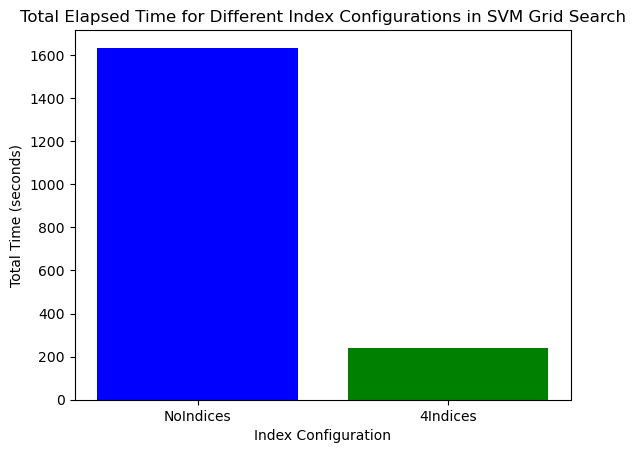

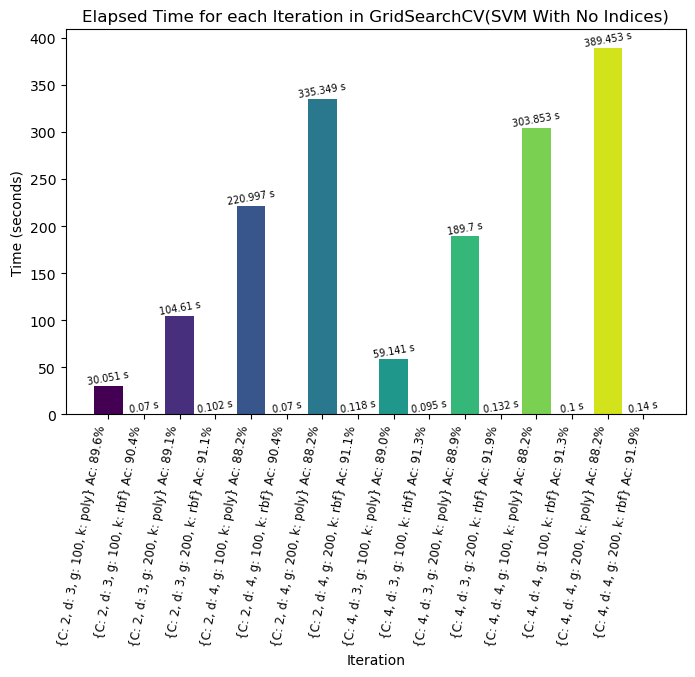

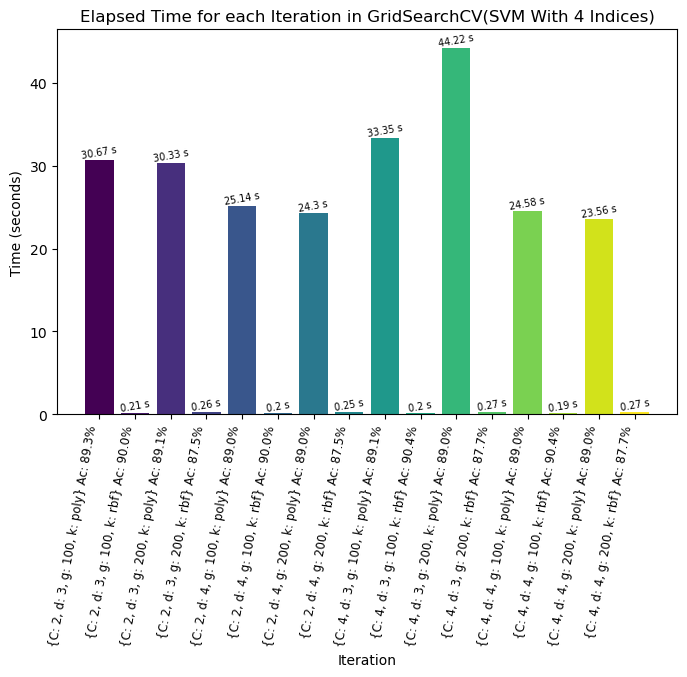

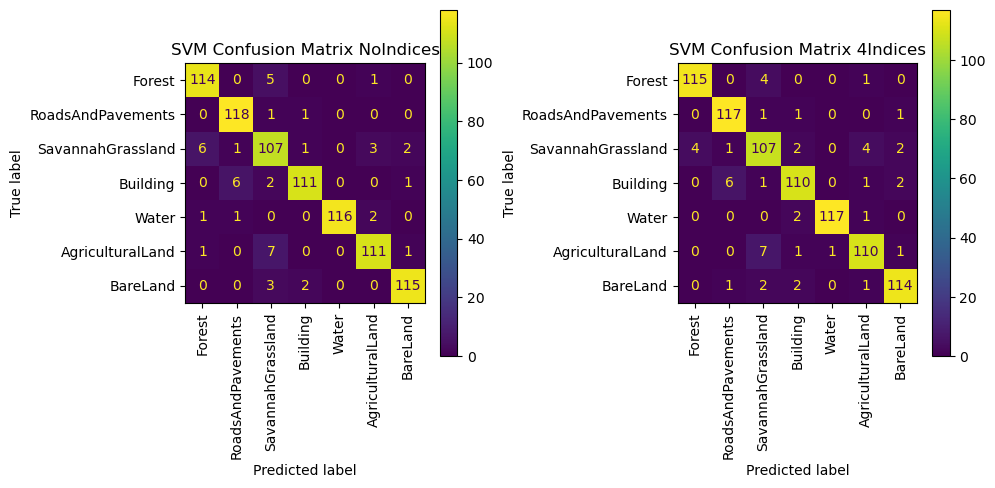

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2683/2683 [17:34<00:00,  2.55it/s]


In [12]:
# Load the pretrained models and grids
Loaded_SVMGridWithNoIndices = joblib.load('./Data/Outputs/Grids/SVMGrid_WithNoIndices_CompleteGrid.pkl')
Loaded_SVMGridWith4Indices = joblib.load('./Data/Outputs/Grids/SVMGrid_With4Indices_CompleteGrid.pkl')
Loaded_SVMBestModelWithNoIndices = joblib.load('./Data/Outputs//Models/SVM_WithNoIndicesGrid_BestModel0944047619047619.joblib')
Loaded_SVMBestModelWith4Indices = joblib.load('./Data/Outputs/Models/SVM_With4IndicesGrid_BestModel09380952380952381.joblib')


# Show the accuracies
SVM_accuracyNoIndices = Loaded_SVMBestModelWithNoIndices.score(testData_SVM_NoIndice, testLabel_SVM_NoIndice)
SVM_accuracy4Indices = Loaded_SVMBestModelWith4Indices.score(testData_SVM_4Indice, testLabel_SVM_4Indice)
print("The classification accuracy of SVM for No Indices is {:.4f}\n".format(SVM_accuracyNoIndices))
print("The classification accuracy of SVM for 4 Indices is {:.4f}\n".format(SVM_accuracy4Indices))
TestPrediction_SVMBestModelWithNoIndices = Loaded_SVMBestModelWithNoIndices.predict(testData_SVM_NoIndice)
TestPrediction_SVMBestModelWith4Indices = Loaded_SVMBestModelWith4Indices.predict(testData_SVM_4Indice)
# Generating Classification Report
labels = ['Forest','RoadsAndPavements','SavannahGrassland','Building','Water','AgriculturalLand', 'BareLand']


# Show the classification reports
print('Classification Report for Loaded_SVMBestModelWithNoIndices')
print(classification_report(testLabel_SVM_NoIndice, TestPrediction_SVMBestModelWithNoIndices, target_names=labels))
print('Classification Report for Loaded_SVMBestModelWith4Indices')
print(classification_report(testLabel_SVM_4Indice, TestPrediction_SVMBestModelWith4Indices, target_names=labels))


# Get the time taken for grid time complexity
ET_SVMGridWithNoIndices = Loaded_SVMGridWithNoIndices.cv_results_['mean_fit_time']
ET_SVMGridWith4Indices = Loaded_SVMGridWith4Indices.cv_results_['mean_fit_time']
Total_ET_SVMGridWithNoIndices = Loaded_SVMGridWithNoIndices.cv_results_['mean_fit_time'].sum()
Total_ET_SVMGridWith4Indices = Loaded_SVMGridWith4Indices.cv_results_['mean_fit_time'].sum()
print("Total Grid Elapsed time for No Index : {:.2f} seconds".format(Total_ET_SVMGridWithNoIndices))
print("Total Grid Elapsed time for 4 Index : {:.2f} seconds".format(Total_ET_SVMGridWith4Indices))


# Create a bar plot for the total training time of the grid
indices = ['NoIndices', '4Indices']
total_elapsed_times = [Total_ET_SVMGridWithNoIndices, Total_ET_SVMGridWith4Indices]
bar_colors = ['blue', 'green']
plt.bar(indices, total_elapsed_times, color=bar_colors)
plt.xlabel('Index Configuration')
plt.ylabel('Total Time (seconds)')
plt.title('Total Elapsed Time for Different Index Configurations in SVM Grid Search')
plt.show()


# Create a barplot for individual iteration time complexity: for NoIndices
plt.figure(figsize=(8, 5))
iteration_accuracies_svmNoindice = [round(item * 100, 1) for item in Loaded_SVMGridWithNoIndices.cv_results_['mean_test_score']]
iteration_params_svmNoindice = [f"{param} Ac: {accuracy}%" for param, accuracy in zip(
    [str(item).replace('degree', 'd').replace('gamma','g').replace('kernel','k').replace("'","") for item in Loaded_SVMGridWithNoIndices.cv_results_['params']],
    iteration_accuracies_svmNoindice)]
ET_SVMGridWithNoIndices_Rounded = [round(item , 3) for item in ET_SVMGridWithNoIndices]
plt.bar(iteration_params_svmNoindice, ET_SVMGridWithNoIndices, color=plt.cm.viridis(np.linspace(0, 1, len(ET_SVMGridWithNoIndices))))
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')
plt.title('Elapsed Time for each Iteration in GridSearchCV(SVM With No Indices)')
# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=80, fontsize=8.5, ha='right')  # Adjust font size and justification
for i, v in enumerate(ET_SVMGridWithNoIndices_Rounded):
    plt.text(i, ET_SVMGridWithNoIndices[i], str(v)+' s', ha='center', va='bottom', fontsize=7, rotation=10)
plt.show()



# Create a barplot for individual iteration time complexity: for 4Indices
plt.figure(figsize=(8, 5))
iteration_accuracies_svm4indice = [round(item * 100, 1) for item in Loaded_SVMGridWith4Indices.cv_results_['mean_test_score']]
iteration_params_svm4indice = [f"{param} Ac: {accuracy}%" for param, accuracy in zip(
    [str(item).replace('degree', 'd').replace('gamma','g').replace('kernel','k').replace("'","")  for item in Loaded_SVMGridWith4Indices.cv_results_['params']],
    iteration_accuracies_svm4indice)]
ET_SVMGridWith4Indices_Rounded = [round(item , 2) for item in ET_SVMGridWith4Indices]
plt.bar(iteration_params_svm4indice, ET_SVMGridWith4Indices, color=plt.cm.viridis(np.linspace(0, 1, len(ET_SVMGridWith4Indices))))
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')
plt.title('Elapsed Time for each Iteration in GridSearchCV(SVM With 4 Indices)')
# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=80, fontsize=8.5, ha='right')  # Adjust font size and justification
# Place accuracy labels on each bar
for i, v in enumerate(ET_SVMGridWith4Indices_Rounded):
    plt.text(i, ET_SVMGridWith4Indices[i], str(v)+' s', ha='center', va='bottom', fontsize=7, rotation=10)
plt.show()


# Generating and plotting the confusion matrices
ConfusionMatrix_SVM_NoIndices = confusion_matrix(testLabel_SVM_NoIndice, TestPrediction_SVMBestModelWithNoIndices, labels=Loaded_SVMBestModelWithNoIndices.classes_)
ConfusionMatrix_SVM_4Indices = confusion_matrix(testLabel_SVM_4Indice, TestPrediction_SVMBestModelWith4Indices, labels=Loaded_SVMBestModelWith4Indices.classes_)
fig, axs = plt.subplots(1,2, figsize=(10, 5))
ConfusionMatrixDisplay(confusion_matrix=ConfusionMatrix_SVM_NoIndices, display_labels=labels).plot(ax=axs[0], xticks_rotation=90)
axs[0].set_title('SVM Confusion Matrix NoIndices')
ConfusionMatrixDisplay(confusion_matrix=ConfusionMatrix_SVM_4Indices, display_labels=labels).plot(ax=axs[1], xticks_rotation=90)
axs[1].set_title('SVM Confusion Matrix 4Indices')
plt.tight_layout()
plt.show()
fig.savefig('SVM ConfusionMatrix', dpi=300)

# Saving the classified Image
BandDataNoIndex = BandData[0:12]
BandData4Index =  BandData[0:16]
imgPrediction_SVM_NoIndices = imagePrediction(Loaded_SVMBestModelWithNoIndices, BandDataNoIndex, 'SVM')
imgPrediction_SVM_4Indices = imagePrediction(Loaded_SVMBestModelWith4Indices, BandData4Index, 'SVM')
allSVMImages = {'NoIndices': imgPrediction_SVM_NoIndices,
                '4Indices': imgPrediction_SVM_4Indices}
for name, svmImage in allSVMImages.items():
    # Define the output file path based on the model name
    OutputFilePath_SVM = f"./Data/Outputs/Classified/SVM_{name}Grid_classified.tif"
    with rio.open(OutputFilePath_SVM, 'w', driver='GTiff', width=svmImage.shape[1],
                  height=svmImage.shape[0], count=1, crs=BandsCrs,
                  transform=BandsAffineTransform, dtype=np.uint8) as output:
        output.write(svmImage, 1)
    Image.fromarray(255*(svmImage==2).astype(np.uint8)).show()

**Training and Fitting Model - Random Forest**

In [13]:
#Random Forest
trainData_RF_NoIndice = np.array(trainDataNoIndice)
testData_RF_NoIndice = np.array(testDataNoIndice)
trainLabel_RF_NoIndice = keras.utils.to_categorical(trainLabelNoIndice)
testLabel_RF_NoIndice = keras.utils.to_categorical(testLabelNoIndice)

trainData_RF_4Indice = np.array(trainData4Indice)
testData_RF_4Indice = np.array(testData4Indice)
trainLabel_RF_4Indice = keras.utils.to_categorical(trainLabel4Indice)
testLabel_RF_4Indice = keras.utils.to_categorical(testLabel4Indice)

In [14]:
'''This section contains the code for training the whole grid for RF and a lengthy process. If you want to train again
uncomment the section and run it'''
# # defining parameter distribution for random search
# ParamDistribution_RF = {
#     'n_estimators': [200, 500, 1000, 1500],
#     'criterion': ['gini', 'entropy', 'log_loss']
# }
# RF_Grid_WithNoIndices= GridSearchCV(RandomForestClassifier(random_state=9),ParamDistribution_RF, refit = True, verbose = 3,
#                                     cv=2).fit(trainData_RF_NoIndice, trainLabel_RF_NoIndice)
# # accessing the best model and its hyperparameters
# RF_Grid_WithINoIndices_BestModel = RF_Grid_WithNoIndices.best_estimator_
# RF_Grid_WithNoIndices_BestParams = RF_Grid_WithNoIndices.best_params_
# # evaluating the best models on the test data
# RF_accuracyNoIndices = RF_Grid_WithINoIndices_BestModel.score(testData_RF_NoIndice, testLabel_RF_NoIndice)
# print("The classification accuracy for NoIndice is {:.4f}".format(RF_accuracyNoIndices))



# RF_Grid_With4Indices= GridSearchCV(RandomForestClassifier(random_state=9), ParamDistribution_RF, refit = True, verbose = 3,
#                                    cv=2).fit(trainData_RF_4Indice, trainLabel_RF_4Indice)
# RF_Grid_WithI4Indices_BestModel = RF_Grid_With4Indices.best_estimator_
# RF_Grid_With4Indices_BestParams = RF_Grid_With4Indices.best_params_
# RF_accuracy4Indices = RF_Grid_WithI4Indices_BestModel.score(testData_RF_4Indice, testLabel_RF_4Indice)
# print("The classification accuracy for 4 Indice is {:.4f}".format(RF_accuracy4Indices))


# # Saving the complete grid, will be needed for the time complexity computation
# joblib.dump(RF_Grid_WithNoIndices, './Data/Grids/RF_Grid_WithNoIndices_CompleteGrid.pkl')
# joblib.dump(RF_Grid_With4Indices, './Data/Grids/RF_Grid_With4Indices_CompleteGrid.pkl')
# # Saving the model
# dump(RF_Grid_WithINoIndices_BestModel, './Data/Outputs/Models/RF_WithNoIndicesGrid_BestModel'+str(RF_accuracyNoIndices).replace('.','')+'.joblib')
# dump(RF_Grid_WithI4Indices_BestModel, './Data/Outputs/Models/RF_With4IndicesGrid_BestModel'+str(RF_accuracy4Indices).replace('.','')+'.joblib')

The classification accuracy of RF for No Indices is 0.8964

The classification accuracy of RF for 4 Indices is 0.9000

Classification Report for Loaded_RFBestModelWithNoIndices
                   precision    recall  f1-score   support

           Forest       0.66      0.93      0.77       120
RoadsAndPavements       0.95      0.92      0.93       120
SavannahGrassland       0.89      0.84      0.87       120
         Building       0.97      0.85      0.91       120
            Water       1.00      0.97      0.99       120
 AgriculturalLand       1.00      0.84      0.91       120
         BareLand       0.94      0.93      0.93       120

         accuracy                           0.90       840
        macro avg       0.92      0.90      0.90       840
     weighted avg       0.92      0.90      0.90       840

Classification Report for Loaded_RFBestModelWith4Indices
                   precision    recall  f1-score   support

           Forest       0.70      0.95      0.80      

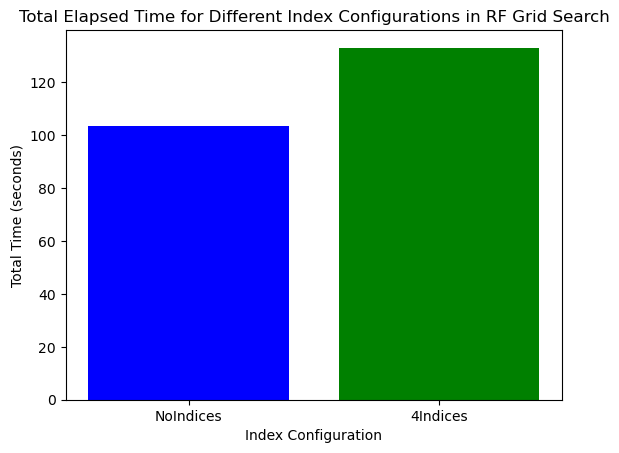

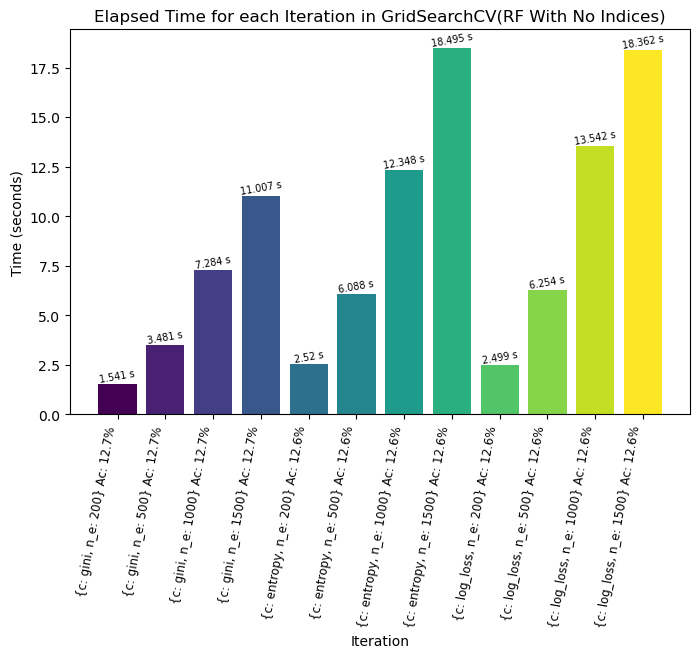

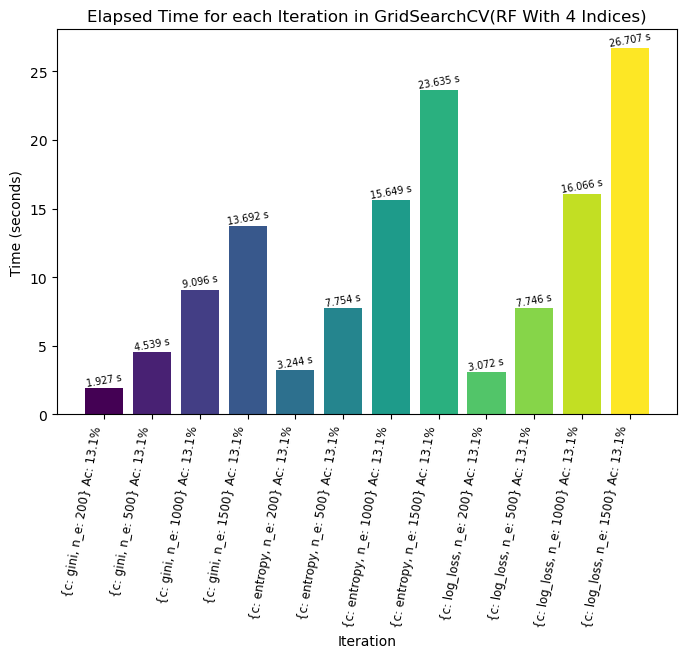

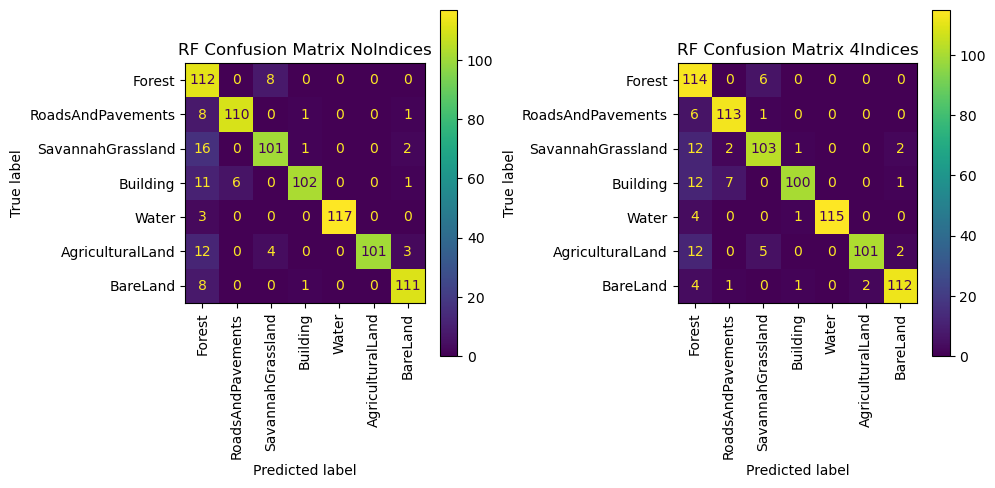

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2683/2683 [1:16:26<00:00,  1.71s/it]


In [15]:
Loaded_RFGridWithNoIndices = joblib.load('./Data/Outputs/Grids/RF_Grid_WithNoIndices_CompleteGrid.pkl')
Loaded_RFGridWith4Indices = joblib.load('./Data/Outputs/Grids/RF_Grid_With4Indices_CompleteGrid.pkl')
Loaded_RFBestModelWithNoIndices = joblib.load('./Data/Outputs/Models/RF_WithNoIndicesGrid_BestModel08952380952380953.joblib')
Loaded_RFBestModelWith4Indices = joblib.load('./Data/Outputs/Models/RF_With4IndicesGrid_BestModel09.joblib')

RF_accuracyNoIndices = Loaded_RFBestModelWithNoIndices.score(testData_RF_NoIndice, testLabel_RF_NoIndice)
RF_accuracy4Indices = Loaded_RFBestModelWith4Indices.score(testData_RF_4Indice, testLabel_RF_4Indice)
print("The classification accuracy of RF for No Indices is {:.4f}\n".format(RF_accuracyNoIndices))
print("The classification accuracy of RF for 4 Indices is {:.4f}\n".format(RF_accuracy4Indices))

TestPrediction_RFBestModelWithNoIndices = np.argmax(Loaded_RFBestModelWithNoIndices.predict(testData_RF_NoIndice), axis=1)
TestPrediction_RFBestModelWith4Indices = np.argmax(Loaded_RFBestModelWith4Indices.predict(testData_RF_4Indice), axis=1)

print('Classification Report for Loaded_RFBestModelWithNoIndices')
print(classification_report(np.argmax(testLabel_RF_NoIndice, axis=1), TestPrediction_RFBestModelWithNoIndices, target_names=labels))
print('Classification Report for Loaded_RFBestModelWith4Indices')
print(classification_report(np.argmax(testLabel_RF_4Indice,axis=1), TestPrediction_RFBestModelWith4Indices, target_names=labels))

# Get the time taken for each iteration
ET_RFGridWithNoIndices = Loaded_RFGridWithNoIndices.cv_results_['mean_fit_time']
ET_RFGridWith4Indices = Loaded_RFGridWith4Indices.cv_results_['mean_fit_time']
Total_ET_RFGridWithNoIndices = Loaded_RFGridWithNoIndices.cv_results_['mean_fit_time'].sum()
Total_ET_RFGridWith4Indices = Loaded_RFGridWith4Indices.cv_results_['mean_fit_time'].sum()
print("Total Grid Elapsed time for No Index : {:.2f} seconds".format(Total_ET_RFGridWithNoIndices))
print("Total Grid Elapsed time for 4 Index : {:.2f} seconds".format(Total_ET_RFGridWith4Indices))

# Create a bar plot for the total grid fitting time 
indices = ['NoIndices', '4Indices']
total_elapsed_times = [Total_ET_RFGridWithNoIndices, Total_ET_RFGridWith4Indices]
bar_colors = ['blue', 'green']
plt.bar(indices, total_elapsed_times, color=bar_colors)
plt.xlabel('Index Configuration')
plt.ylabel('Total Time (seconds)')
plt.title('Total Elapsed Time for Different Index Configurations in RF Grid Search')
plt.show()

# Plot iteration wise time complexity : NoIndices
plt.figure(figsize=(8, 5))
iteration_accuracies_RFNoindice = [round(item * 100, 1) for item in Loaded_RFGridWithNoIndices.cv_results_['mean_test_score']]
iteration_params_RFNoindice = [f"{param} Ac: {accuracy}%" for param, accuracy in zip(
    [str(item).replace('criterion', 'c').replace('n_estimators','n_e').replace("'","") for item in Loaded_RFGridWithNoIndices.cv_results_['params']],
    iteration_accuracies_RFNoindice)]
ET_RFGridWithNoIndices_Rounded = [round(item , 3) for item in ET_RFGridWithNoIndices]
plt.bar(iteration_params_RFNoindice, ET_RFGridWithNoIndices, color=plt.cm.viridis(np.linspace(0, 1, len(ET_RFGridWithNoIndices))))
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')
plt.title('Elapsed Time for each Iteration in GridSearchCV(RF With No Indices)')
# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=80, fontsize=8.5, ha='right')  # Adjust font size and justification
for i, v in enumerate(ET_RFGridWithNoIndices_Rounded):
    plt.text(i, ET_RFGridWithNoIndices[i], str(v)+' s', ha='center', va='bottom', fontsize=7, rotation=10)
plt.show()


# Plot iteration wise time complexity : 4Indices
plt.figure(figsize=(8, 5))
iteration_accuracies_RF4indice = [round(item * 100, 1) for item in Loaded_RFGridWith4Indices.cv_results_['mean_test_score']]
iteration_params_RF4indice = [f"{param} Ac: {accuracy}%" for param, accuracy in zip(
    [str(item).replace('criterion', 'c').replace('n_estimators','n_e').replace("'","") for item in Loaded_RFGridWith4Indices.cv_results_['params']],
    iteration_accuracies_RF4indice)]
ET_RFGridWith4Indices_Rounded = [round(item , 3) for item in ET_RFGridWith4Indices]
plt.bar(iteration_params_RF4indice, ET_RFGridWith4Indices, color=plt.cm.viridis(np.linspace(0, 1, len(ET_RFGridWith4Indices))))
plt.xlabel('Iteration')
plt.ylabel('Time (seconds)')
plt.title('Elapsed Time for each Iteration in GridSearchCV(RF With 4 Indices)')
# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=80, fontsize=8.5, ha='right')  # Adjust font size and justification
for i, v in enumerate(ET_RFGridWith4Indices_Rounded):
    plt.text(i, ET_RFGridWith4Indices[i], str(v)+' s', ha='center', va='bottom', fontsize=7, rotation=10)
plt.show()

# Plotting the confusion matrix
# Generating the confusion matrices
ConfusionMatrix_RF_NoIndices = confusion_matrix(np.array(np.argmax(testLabel_RF_NoIndice, axis=1)), TestPrediction_RFBestModelWithNoIndices , labels=list(range(len(Loaded_RFBestModelWithNoIndices.classes_))))
ConfusionMatrix_RF_4Indices = confusion_matrix(np.array(np.argmax(testLabel_RF_4Indice, axis=1)), TestPrediction_RFBestModelWith4Indices , labels=list(range(len(Loaded_RFBestModelWith4Indices.classes_))))
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10,5))
# Plot each confusion matrix
ConfusionMatrixDisplay(confusion_matrix=ConfusionMatrix_RF_NoIndices, display_labels=labels).plot(ax=axs[0], xticks_rotation=90)
axs[0].set_title('RF Confusion Matrix NoIndices')
ConfusionMatrixDisplay(confusion_matrix=ConfusionMatrix_RF_4Indices, display_labels=labels).plot(ax=axs[1], xticks_rotation=90)
axs[1].set_title('RF Confusion Matrix 4Indices')
plt.tight_layout()
plt.show()
fig.savefig('RF Confusion Matrix', dpi=300)

# Saving the classified Image
imgPrediction_RF_NoIndices = imagePrediction(Loaded_RFBestModelWithNoIndices, BandDataNoIndex, 'RF')
imgPrediction_RF_4Indices = imagePrediction(Loaded_RFBestModelWith4Indices, BandData4Index, 'RF')
allRFImages = {'NoIndices': imgPrediction_RF_NoIndices,
                '4Indices': imgPrediction_RF_4Indices}
for name, RFImage in allRFImages.items():
    # Define the output file path based on the model name
    OutputFilePath_RF = f"./Data/Outputs/Classified/RF_{name}Grid_classified.tif"
    with rio.open(OutputFilePath_RF, 'w', driver='GTiff', width=RFImage.shape[1],
                  height=RFImage.shape[0], count=1, crs=BandsCrs,
                  transform=BandsAffineTransform, dtype=np.uint8) as output:
        output.write(RFImage, 1)
    Image.fromarray(255*(RFImage==2).astype(np.uint8)).show()

**Training and Fitting Model - ANN**

In [16]:
trainData_ANN_NoIndice = np.array(trainDataNoIndice)
testData_ANN_NoIndice = np.array(testDataNoIndice)
trainLabel_ANN_NoIndice = keras.utils.to_categorical(trainLabelNoIndice)
testLabel_ANN_NoIndice = keras.utils.to_categorical(testLabelNoIndice)

trainData_ANN_4Indice = np.array(trainData4Indice)
testData_ANN_4Indice = np.array(testData4Indice)
trainLabel_ANN_4Indice = keras.utils.to_categorical(trainLabel4Indice)
testLabel_ANN_4Indice = keras.utils.to_categorical(testLabel4Indice)

logDirNoIndices = "./Data/Outputs/ANNlogs/Fit_NoIndices/" + datetime.now().strftime("%Y%m%d-%H%M%S")
Tensorboard_Callback_NoIndices = keras.callbacks.TensorBoard(log_dir=logDirNoIndices)
CheckPoint_CB_NoIndices = ModelCheckpoint(filepath="./"+logDirNoIndices+"/checkpoints/model_{epoch:02d}_{val_loss:.4f}_{val_accuracy:.4f}.h5",
    monitor="val_accuracy", save_best_only=True, save_weights_only=False, mode="max", verbose=1)

logDir4Indices = "/Data/Outputs/ANNlogs/Fit_4Indices/" + datetime.now().strftime("%Y%m%d-%H%M%S")
Tensorboard_Callback_4Indices = keras.callbacks.TensorBoard(log_dir=logDir4Indices)
CheckPoint_CB_4Indices = ModelCheckpoint(filepath="./"+logDir4Indices+"/checkpoints/model_{epoch:02d}_{val_loss:.4f}_{val_accuracy:.4f}.h5",
    monitor="val_accuracy",save_best_only=True,save_weights_only=False,mode="max",verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)        
time_callback = timecallback()

In [17]:
'''This section contains the code for training the whole grid for SVM and a lengthy process. If you want to train again
uncomment the section and run it'''

# # Training for NoIndices dataset
# ANN_NoIndicesModel = modelCreate(trainData_ANN_NoIndice, trainLabel_ANN_NoIndice)
# historyANN_NoIndicesModel= ANN_NoIndicesModel.fit(trainData_ANN_NoIndice, trainLabel_ANN_NoIndice, 
#                                                  epochs=500, batch_size=16, verbose=2,  
#                                                  validation_data=(testData_ANN_NoIndice, testLabel_ANN_NoIndice),
#                                                  callbacks=[time_callback, early_stopping,CheckPoint_CB_NoIndices, Tensorboard_Callback_NoIndices])
# ANN_NoIndicesLoss, ANN_NoIndicesAcc, ANN_NoIndicesMAE = ANN_NoIndicesModel.evaluate(testData_ANN_NoIndice, testLabel_ANN_NoIndice)
# print("NoIndices - Loss: {:.4f}, Accuracy: {:.4f}, MAE: {:.4f}".format(ANN_NoIndicesLoss, ANN_NoIndicesAcc,ANN_NoIndicesMAE ))
# ANN_NoIndicesModel.save(f'./{logDirNoIndices}/{logDirNoIndices.split("/")[-1]}_{str(ANN_NoIndicesAcc).replace(".", "")}.h5')
# with open(f'./{logDirNoIndices}/{logDirNoIndices.split("/")[-1]}_History_{str(ANN_NoIndicesAcc).replace(".", "")}', 'wb') as history_file:
#     pickle.dump(historyANN_NoIndicesModel.history, history_file)
# print(logDirNoIndices)

# # Training for 4Indices dataset
# ANN_4IndicesModel = modelCreate(trainData_ANN_4Indice, trainLabel_ANN_4Indice)
# historyANN_4IndicesModel = ANN_4IndicesModel.fit(trainData_ANN_4Indice, trainLabel_ANN_4Indice, 
#                                                  batch_size=16, verbose=2,epochs=500, 
#                                                  validation_data=(testData_ANN_4Indice, testLabel_ANN_4Indice),
#                                                  callbacks=[early_stopping, Tensorboard_Callback_4Indices, time_callback, CheckPoint_CB_4Indices])
# ANN_4IndicesLoss, ANN_4IndicesAcc, ANN_4IndicesMAE = ANN_4IndicesModel.evaluate(testData_ANN_4Indice, testLabel_ANN_4Indice)
# print("4Indices - Loss: {:.4f}, Accuracy: {:.4f}, MAE: {:.4f}".format(ANN_4IndicesLoss, ANN_4IndicesAcc,ANN_4IndicesMAE ))
# ANN_4IndicesModel.save(f'./{logDir4Indices}/{logDir4Indices.split("/")[-1]}_{str(ANN_4IndicesAcc).replace(".", "")}.h5')
# with open(f'./{logDir4Indices}/{logDir4Indices.split("/")[-1]}_History_{str(ANN_4IndicesAcc).replace(".", "")}', 'wb') as history_file:
#     joblib.dump(historyANN_4IndicesModel.history, history_file)
# print(logDir4Indices)

# plot_model(ANN_NoIndicesModel,to_file='modelANNNoIndices.png',show_shapes=True,show_dtype=False,show_layer_names=True,
#     rankdir='TB',expand_nested=True,dpi=300,layer_range=None,show_layer_activations=True,show_trainable=True)

# plot_model(ANN_4IndicesModel,to_file='modelANN4Indices.png',show_shapes=True,show_dtype=False,show_layer_names=True,
#     rankdir='TB',expand_nested=True,dpi=300,layer_range=None,show_layer_activations=True,show_trainable=True)


# # ANN_NoIndicesModel.save('./Data/Outputs/Models/ANN_WithNoIndices_Model'+str(ANN_NoIndicesAcc).replace('.','')+'.h5')
# # ANN_4IndicesModel.save('./Data/Outputs/Models/ANN_With4Indices_Model'+str(ANN_4IndicesAcc).replace('.','')+'.h5')

27/27 [==============================] - 0s 2ms/step - loss: 0.3729 - accuracy: 0.8833 - mae: 0.0584
NoIndices - Loss: 0.3729, Accuracy: 0.8833
27/27 [==============================] - 0s 3ms/step - loss: 0.2971 - accuracy: 0.9024 - mae: 0.0457
4Indices - Loss: 0.2971, Accuracy: 0.9024
27/27 [==============================] - 0s 2ms/step
	
----Classification Report for ANN NoIndice----
                   precision    recall  f1-score   support

           Forest       0.87      0.93      0.90       120
RoadsAndPavements       0.84      0.94      0.89       120
SavannahGrassland       0.77      0.76      0.76       120
         Building       0.97      0.86      0.91       120
            Water       0.94      0.97      0.95       120
 AgriculturalLand       0.89      0.83      0.86       120
         BareLand       0.90      0.90      0.90       120

         accuracy                           0.88       840
        macro avg       0.89      0.88      0.88       840
     weighted avg  

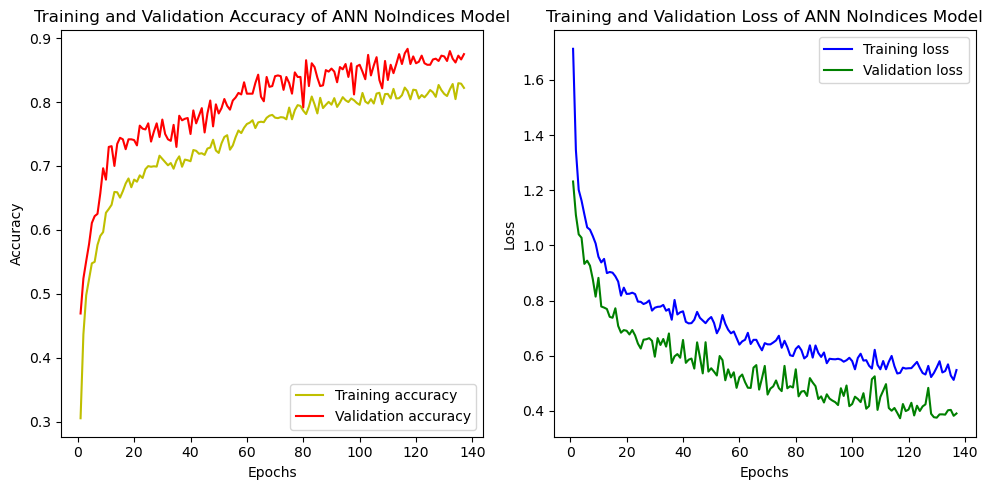

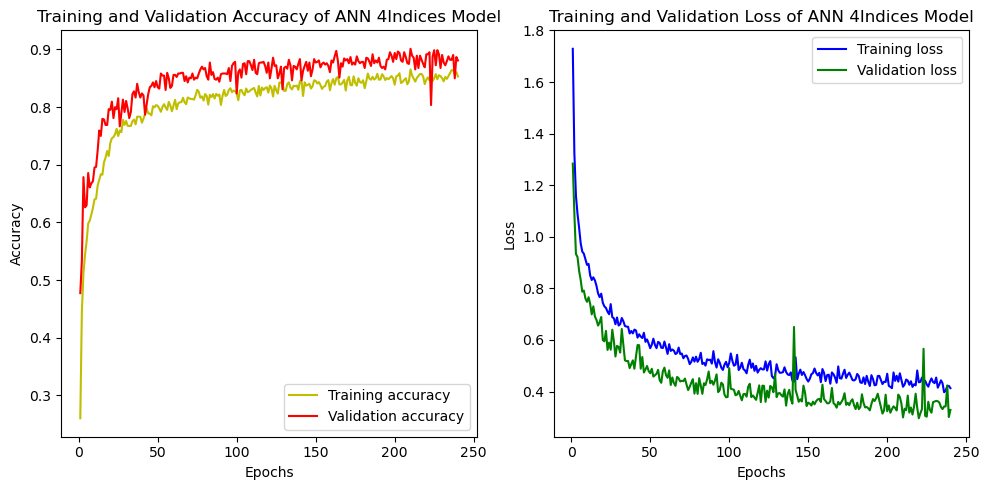

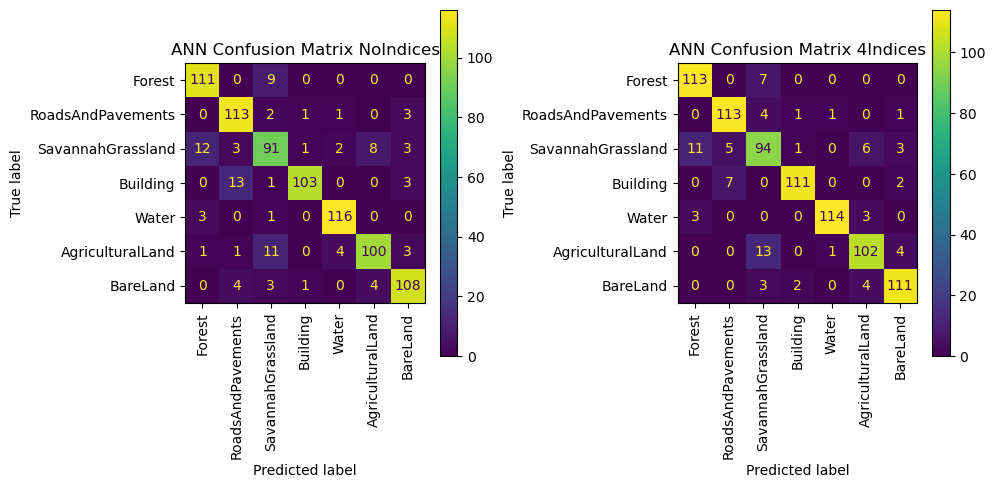

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2683/2683 [07:51<00:00,  5.69it/s]


In [20]:
# Loading pretrained models
Loaded_ANN_NoIndicesModel = keras.models.load_model("./Data/Outputs/Models/ANN_WithNoIndices_model_117_0.3735_0.8833.h5")
Loaded_ANN_4IndicesModel = keras.models.load_model("./Data/Outputs/Models/ANN_With4Indices_model_210_0.2997_0.9012.h5")

#Loading the histories
with open('./Data/Outputs/Models/ANN_WithNoIndices_model_117_20230918-230556_History_0875', "rb") as historyfile:
    Loaded_ANN_NoIndicesModelHist = joblib.load(historyfile)
with open('./Data/Outputs/Models/ANN_With4Indices_model_210_20230918-232339_History_08809523582458496', "rb") as historyfile:
    Loaded_ANN_4IndicesModelHist = joblib.load(historyfile)

ANN_NoIndicesLoss, ANN_NoIndicesAcc, ANN_NoIndicesMae=Loaded_ANN_NoIndicesModel.evaluate(testData_ANN_NoIndice,testLabel_ANN_NoIndice)
print("NoIndices - Loss: {:.4f}, Accuracy: {:.4f}".format(ANN_NoIndicesLoss, ANN_NoIndicesAcc ))
ANN_4IndicesLoss, ANN_4IndicesAcc, ANN_4IndicesMae=Loaded_ANN_4IndicesModel.evaluate(testData_ANN_4Indice,testLabel_ANN_4Indice)
print("4Indices - Loss: {:.4f}, Accuracy: {:.4f}".format(ANN_4IndicesLoss, ANN_4IndicesAcc ))

TestPrediction_ANNModelWithNoIndices = np.argmax(Loaded_ANN_NoIndicesModel.predict(testData_ANN_NoIndice), axis=-1)
TestPrediction_ANNModelWith4Indices = np.argmax(Loaded_ANN_4IndicesModel.predict(testData_ANN_4Indice), axis=-1)

print('\t\n----Classification Report for ANN NoIndice----')
print(classification_report(np.argmax(testLabel_ANN_NoIndice, axis=-1), TestPrediction_ANNModelWithNoIndices,  target_names=labels))
print('\t\n----Classification Report for ANN 4Indice----')
print(classification_report(np.argmax(testLabel_ANN_4Indice, axis=-1), TestPrediction_ANNModelWith4Indices,  target_names=labels))


Loaded_ANN_NoIndicesModelHist_Accs = Loaded_ANN_NoIndicesModelHist['accuracy']
Loaded_ANN_NoIndicesModelHist_epochs = range(1, len(Loaded_ANN_NoIndicesModelHist_Accs) + 1)
Loaded_ANN_NoIndicesModelHist_ValAccs = Loaded_ANN_NoIndicesModelHist['val_accuracy']
Loaded_ANN_NoIndicesModelHist_losses = Loaded_ANN_NoIndicesModelHist['loss']
Loaded_ANN_NoIndicesModelHist_ValLosses = Loaded_ANN_NoIndicesModelHist['val_loss']

plt.figure(figsize=(10, 5))  # Adjust figure size as needed

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(Loaded_ANN_NoIndicesModelHist_epochs, Loaded_ANN_NoIndicesModelHist_Accs, 'y', label='Training accuracy')
plt.plot(Loaded_ANN_NoIndicesModelHist_epochs, Loaded_ANN_NoIndicesModelHist_ValAccs, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy of ANN NoIndices Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(Loaded_ANN_NoIndicesModelHist_epochs, Loaded_ANN_NoIndicesModelHist_losses, 'b', label='Training loss')
plt.plot(Loaded_ANN_NoIndicesModelHist_epochs, Loaded_ANN_NoIndicesModelHist_ValLosses, 'g', label='Validation loss')
plt.title('Training and Validation Loss of ANN NoIndices Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('ANN_NoIndices_Training_Plot.png', dpi=300)
plt.show()


Loaded_ANN_4IndicesModelHist_Accs = Loaded_ANN_4IndicesModelHist['accuracy']
Loaded_ANN_4IndicesModelHist_epochs = range(1, len(Loaded_ANN_4IndicesModelHist_Accs) + 1)
Loaded_ANN_4IndicesModelHist_ValAccs = Loaded_ANN_4IndicesModelHist['val_accuracy']
Loaded_ANN_4IndicesModelHist_losses = Loaded_ANN_4IndicesModelHist['loss']
Loaded_ANN_4IndicesModelHist_ValLosses = Loaded_ANN_4IndicesModelHist['val_loss']

plt.figure(figsize=(10, 5))  # Adjust figure size as needed

# Plot training accuracy and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(Loaded_ANN_4IndicesModelHist_epochs, Loaded_ANN_4IndicesModelHist_Accs, 'y', label='Training accuracy')
plt.plot(Loaded_ANN_4IndicesModelHist_epochs, Loaded_ANN_4IndicesModelHist_ValAccs, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy of ANN 4Indices Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training loss and validation loss
plt.subplot(1, 2, 2)
plt.plot(Loaded_ANN_4IndicesModelHist_epochs, Loaded_ANN_4IndicesModelHist_losses, 'b', label='Training loss')
plt.plot(Loaded_ANN_4IndicesModelHist_epochs, Loaded_ANN_4IndicesModelHist_ValLosses, 'g', label='Validation loss')
plt.title('Training and Validation Loss of ANN 4Indices Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
# Save the plot as an image file (e.g., PNG)
plt.savefig('ANN_4Indices_Training_Plot.png', dpi= 300)
# Show the plot
plt.show()


# Generating the confusion matrices
ConfusionMatrix_ANN_NoIndices = confusion_matrix(np.argmax(testLabel_ANN_NoIndice, axis=-1), TestPrediction_ANNModelWithNoIndices)
ConfusionMatrix_ANN_4Indices = confusion_matrix(np.argmax(testLabel_ANN_4Indice, axis=-1), TestPrediction_ANNModelWith4Indices)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# Plot each confusion matrix
ConfusionMatrixDisplay(confusion_matrix=ConfusionMatrix_ANN_NoIndices, display_labels=labels).plot(ax=axs[0], xticks_rotation=90)
axs[0].set_title('ANN Confusion Matrix NoIndices')
ConfusionMatrixDisplay(confusion_matrix=ConfusionMatrix_ANN_4Indices, display_labels=labels).plot(ax=axs[1], xticks_rotation=90)
axs[1].set_title('ANN Confusion Matrix 4Indices')
plt.tight_layout()
plt.show()
fig.savefig('ANN Confusion Matrix', dpi=300)


# Predicting for whole image
tf.keras.utils.disable_interactive_logging()
imgPrediction_ANN_NoIndices = imagePrediction(Loaded_ANN_NoIndicesModel, BandDataNoIndex, 'ANN')
imgPrediction_ANN_4Indices = imagePrediction(Loaded_ANN_4IndicesModel, BandData4Index, 'ANN')

allANNImages = {
    'NoIndices': imgPrediction_ANN_NoIndices,
    '4Indices': imgPrediction_ANN_4Indices}



for name, annimage in allANNImages.items():
    # Define the output file path based on the model name
    OutputFilePath_RF = f"./Data/Outputs/Classified/ANN_{name}_classified.tif"
    with rio.open(OutputFilePath_RF, 'w', driver='GTiff', width=annimage.shape[1],
                  height=annimage.shape[0], count=1, crs=BandsCrs,transform=BandsAffineTransform, dtype=np.uint8) as output:
        output.write(annimage, 1)
    Image.fromarray(255*(annimage==2).astype(np.uint8)).show()

### New Approach (Selection)

In [21]:
# # Define class labels
# classes = labels

# # Create a dictionary to store confusion matrices
# ConfusionMatrices = {
#     'SVM_NoIndices': ConfusionMatrix_SVM_NoIndices,
#     'SVM_4Indices': ConfusionMatrix_SVM_4Indices,
#     'RF_NoIndices': ConfusionMatrix_RF_NoIndices,
#     'RF_4Indices': ConfusionMatrix_RF_4Indices,
#     'ANN_NoIndices': ConfusionMatrix_ANN_NoIndices,
#     'ANN_4Indices': ConfusionMatrix_ANN_4Indices
# }

# ClassificationReports = {
#     'SVM_NoIndices': classification_report(testLabel_SVM_NoIndice, TestPrediction_SVMBestModelWithNoIndices, target_names=labels, output_dict=True),
#     'SVM_4Indices': classification_report(testLabel_SVM_4Indice, TestPrediction_SVMBestModelWith4Indices, target_names=labels, output_dict=True),
#     'RF_NoIndices': classification_report(np.argmax(testLabel_RF_NoIndice, axis=-1), TestPrediction_RFBestModelWithNoIndices, target_names=labels, output_dict=True),
#     'RF_4Indices': classification_report(np.argmax(testLabel_RF_4Indice, axis=-1), TestPrediction_RFBestModelWith4Indices, target_names=labels, output_dict=True),
#     'ANN_NoIndices': classification_report(np.argmax(testLabel_ANN_NoIndice, axis=-1), TestPrediction_ANNModelWithNoIndices, target_names=labels, output_dict=True),
#     'ANN_4Indices': classification_report(np.argmax(testLabel_ANN_4Indice, axis=-1), TestPrediction_ANNModelWith4Indices, target_names=labels, output_dict=True)
# }

# overallbest = {'modelname':None, 'accuracy':0} # the best model with 



# # Create a dictionary to store the best model names for each class
# best_models_per_class = {}

# # Iterate through classes
# for index, cls in enumerate(classes):
#     cls_best_model = None
#     curr_best = 0  # current best score for this class
    
#     for name, matrix in ConfusionMatrices.items():
#         this_matrix_score = matrix[index][index]
#         if this_matrix_score > curr_best:
#             curr_best = this_matrix_score
#             cls_best_model = name
            
          
#     best_models_per_class[cls] = {'classname':cls, 'classcode':index,'bestmodelname':cls_best_model,'score':(curr_best/120)*100}
# # Create a matrix with the best model names for each class
# best_model_matrix = [best_models_per_class[cls] for cls in classes]

# sorted_best_model_matrix = sorted(best_model_matrix, key=lambda x: x['score'], reverse=True)
# print(sorted_best_model_matrix)


# for name, report in ClassificationReports.items():
#     if report['accuracy'] > overallbest['accuracy']:
#         overallbest['modelname'] = name,            
#         overallbest['accuracy']=report['accuracy']

[{'classname': 'Water', 'classcode': 4, 'bestmodelname': 'SVM_NoIndices', 'score': 1.0}, {'classname': 'AgriculturalLand', 'classcode': 5, 'bestmodelname': 'RF_NoIndices', 'score': 1.0}, {'classname': 'Building', 'classcode': 3, 'bestmodelname': 'ANN_NoIndices', 'score': 0.9716981132075472}, {'classname': 'Forest', 'classcode': 0, 'bestmodelname': 'SVM_4Indices', 'score': 0.9663865546218487}, {'classname': 'BareLand', 'classcode': 6, 'bestmodelname': 'SVM_NoIndices', 'score': 0.9663865546218487}, {'classname': 'RoadsAndPavements', 'classcode': 1, 'bestmodelname': 'RF_NoIndices', 'score': 0.9482758620689655}, {'classname': 'SavannahGrassland', 'classcode': 2, 'bestmodelname': 'RF_4Indices', 'score': 0.8956521739130435}]
Water 4 SVM_NoIndices
AgriculturalLand 5 RF_NoIndices
Building 3 ANN_NoIndices
Forest 0 SVM_4Indices
BareLand 6 SVM_NoIndices
RoadsAndPavements 1 RF_NoIndices
SavannahGrassland 2 RF_4Indices
1300665 undecided pixels


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 840/840 [00:00<00:00, 7685.76it/s]


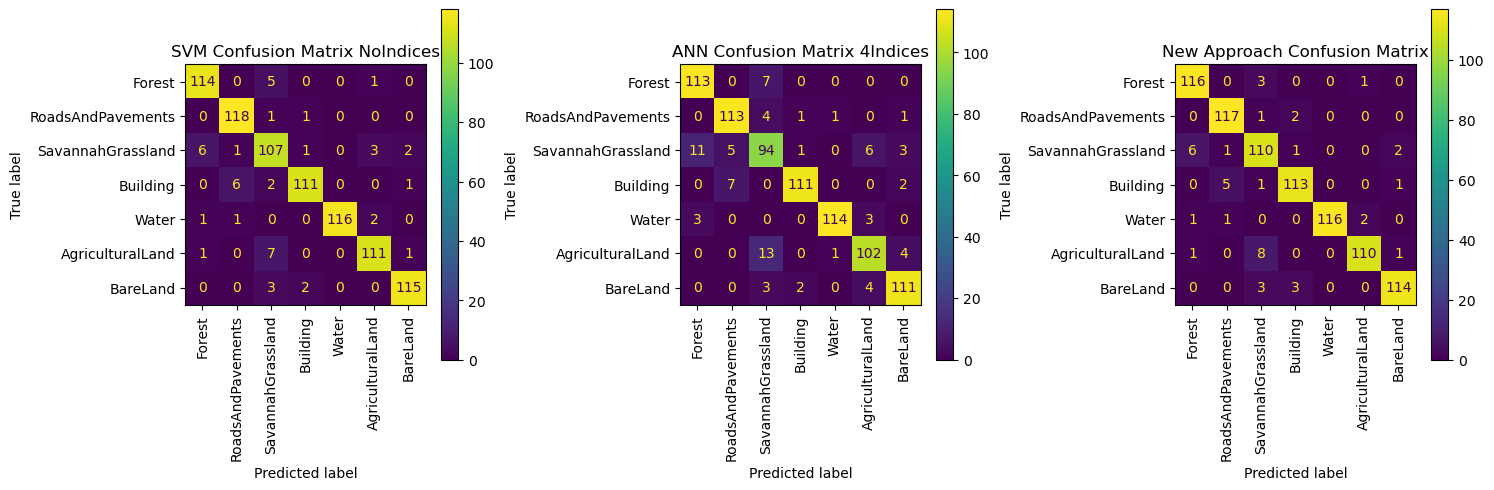

                   precision    recall  f1-score   support

           Forest       0.94      0.97      0.95       120
RoadsAndPavements       0.94      0.97      0.96       120
SavannahGrassland       0.87      0.92      0.89       120
         Building       0.95      0.94      0.95       120
            Water       1.00      0.97      0.98       120
 AgriculturalLand       0.97      0.92      0.94       120
         BareLand       0.97      0.95      0.96       120

         accuracy                           0.95       840
        macro avg       0.95      0.95      0.95       840
     weighted avg       0.95      0.95      0.95       840



In [22]:
# Define class labels
classes = labels#sorted(testing_datawith7Indices_df.lclass.unique())


# Create a dictionary to store confusion matrices
ConfusionMatrices = {
    'SVM_NoIndices': ConfusionMatrix_SVM_NoIndices,
    'SVM_4Indices': ConfusionMatrix_SVM_4Indices,
    'RF_NoIndices': ConfusionMatrix_RF_NoIndices,
    'RF_4Indices': ConfusionMatrix_RF_4Indices,
    'ANN_NoIndices': ConfusionMatrix_ANN_NoIndices,
'ANN_4Indices': ConfusionMatrix_ANN_4Indices}
ClassificationReports = {
    'SVM_NoIndices': classification_report(testLabel_SVM_NoIndice, TestPrediction_SVMBestModelWithNoIndices, target_names=labels, output_dict=True),
    'SVM_4Indices': classification_report(testLabel_SVM_4Indice, TestPrediction_SVMBestModelWith4Indices, target_names=labels, output_dict=True),
    'RF_NoIndices': classification_report(np.argmax(testLabel_RF_NoIndice, axis=-1), TestPrediction_RFBestModelWithNoIndices, target_names=labels, output_dict=True),
    'RF_4Indices': classification_report(np.argmax(testLabel_RF_4Indice, axis=-1), TestPrediction_RFBestModelWith4Indices, target_names=labels, output_dict=True),
    'ANN_NoIndices': classification_report(np.argmax(testLabel_ANN_NoIndice, axis=-1), TestPrediction_ANNModelWithNoIndices, target_names=labels, output_dict=True),
    'ANN_4Indices': classification_report(np.argmax(testLabel_ANN_4Indice, axis=-1), TestPrediction_ANNModelWith4Indices, target_names=labels, output_dict=True)}
overallbest = {'modelname':None, 'precision':0} # to store the best model to fill the undecided pixels
best_models_per_class = {} #a dictionary to store the best model names for each class
# Aggregation to find the rank between the classes. 
for index, cls in enumerate(classes):
    cls_best_model = None
    curr_best = 0  # current best score for this class
    for name, report in ClassificationReports.items():
        if report['weighted avg']['precision'] > overallbest['precision']:
            overallbest['modelname'] = name, 
            overallbest['precision']=report['weighted avg']['precision']
        this_matrix_score = report[cls]['precision']
        if this_matrix_score > curr_best:
            curr_best = this_matrix_score
            cls_best_model = name            
    best_models_per_class[cls] = {'classname':cls, 'classcode':index,'bestmodelname':cls_best_model,'score':curr_best}
best_model_matrix = [best_models_per_class[cls] for cls in classes]
sorted_best_model_matrix = sorted(best_model_matrix, key=lambda x: x['score'], reverse=True) # sorting to based on the score
print(sorted_best_model_matrix)
output_folder = f'{output_path}/Classified/'  # Update this path to your actual folder path
tif_files = [os.path.join(output_folder, filename) for filename in os.listdir(output_folder) if filename.endswith(".tif") and '7Indices' not in filename]


# Initialize an empty dictionary to store the image bands
classifiedImages = {}
for tif_file in tif_files:
    with rio.open(tif_file) as src:
        classifiedimage_name = os.path.splitext(os.path.basename(tif_file))[0].replace('_classified', '').replace('Grid','')  # Extract band name from the filename
        classifiedimage_data = src.read(1)  # Read band data
        classifiedImages[classifiedimage_name] = classifiedimage_data    

finalImage = np.zeros_like(list(classifiedImages.values())[0]) # creating empty image
finalImage[finalImage == 0] = 100 # there is a class as 0, so replacing all pixels with 100

# setting the values in the pixels with the classes based on rank decided
for cls in sorted_best_model_matrix:
    clsname = cls['classname']
    modelname = cls['bestmodelname'] # best model for the class
    band_data = classifiedImages[modelname] # classified image with that model
    classcode = cls['classcode'] # code for the class in classified image
    indices_to_fill = np.argwhere(band_data == classcode)
    
    for i,j in indices_to_fill:
        if finalImage[i][j] == 100:
            finalImage[i][j] = classcode
        else: continue
# filling the undecided pixels with the result from overall best model          
if np.sum(finalImage == 100) >=1:
    print(np.sum(finalImage == 100), 'undecided pixels')
    indices_to_fill = np.argwhere(finalImage == 100)
    
    bestaccuracy_image = classifiedImages[overallbest['modelname'][0]]
    
    for i,j in indices_to_fill:
        if finalImage[i][j] == 100:
            finalImage[i][j] = bestaccuracy_image[i][j]
        else: continue

# Define the output file path
# finalImagePath = "./Data/Outputs/Classified/HybridSelection/HybridSelectionMethodAfterCurves_classified_wpresion.tif"
finalImagePath = f'{output_folder}HybridSelection/HybridSelectionMethodAfterCurves_classified_wpresion.tif'
# Write the finalImage array to a GeoTIFF file
with rio.open(finalImagePath, 'w', driver='GTiff', width=finalImage.shape[1], height=finalImage.shape[0], 
              count=1, crs=BandsCrs,transform=BandsAffineTransform, dtype=np.uint8) as output:
    output.write(finalImage, 1)
    output.close()

# Measuring the accuracy of finalImage
with rio.open(finalImagePath) as src:
    importedFinalImageData = src.read(1)  # Read band data
# Now we are importing our training data
testing_dataset_gpd = gpd.read_file('./Data/Inputs/TrainingTestingData/TestData_Reduced.shp')
testing_dataset_gpd.columns = ['pointid_in_layer','layer_name','lclass','index', 'geometry'] # change the column name id to point_id
testing_dataset_gpd['index'] = testing_dataset_gpd.index #create a new column index
testing_dataset_gpd['id'] = testing_dataset_gpd.index #create a new column index
testing_dataset_gpd.loc[testing_dataset_gpd['lclass'] == 8, 'lclass'] = 3

N=len(testing_dataset_gpd["id"])
testrestults = []
for n in tqdm(range(N)):
    point = testing_dataset_gpd.iloc[n]
    row, col = rio.transform.rowcol(BandsAffineTransform, point.geometry.x, point.geometry.y)
    testrestults.append(importedFinalImageData[row][col])
testing_dataset_gpd['tclass'] = testrestults

# Create the confusion matrix
ConfHybrid = confusion_matrix(testing_dataset_gpd['lclass'].values, testing_dataset_gpd['tclass'].values)
ClassRepHybrid = classification_report(testing_dataset_gpd['lclass'], testing_dataset_gpd['tclass'], target_names=labels, output_dict=True)  
ConfusionMatrices['Hybrid'] = ConfHybrid   
ClassificationReports['Hybrid']=ClassRepHybrid

# Plot each confusion matrix
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
ConfusionMatrixDisplay(confusion_matrix=ConfusionMatrix_SVM_NoIndices, display_labels=labels).plot(ax=axs[0], xticks_rotation=90)
axs[0].set_title('SVM Confusion Matrix NoIndices')
ConfusionMatrixDisplay(confusion_matrix=ConfusionMatrix_ANN_4Indices, display_labels=labels).plot(ax=axs[1], xticks_rotation=90)
axs[1].set_title('ANN Confusion Matrix 4Indices')
ConfusionMatrixDisplay(confusion_matrix=ConfHybrid, display_labels=labels).plot(ax=axs[2], xticks_rotation=90)
axs[2].set_title('New Approach Confusion Matrix')
plt.tight_layout()
plt.show()
fig.savefig('NewApproach Confusion Metrics with others', dpi=300)
print(classification_report(testing_dataset_gpd['lclass'], testing_dataset_gpd['tclass'],  target_names=labels))

**ANN TensorBoard**

In [ ]:
# Load the TensorBoard notebook extension for NoIndices
%reload_ext tensorboard
%load_ext tensorboard
%tensorboard --logdir ./Data/Outputs/ANNlogs/Fit_NoIndices --port=8001

In [ ]:
# # Load the TensorBoard notebook extension for 4 Indices
# %reload_ext tensorboard
# %load_ext tensorboard
%tensorboard --logdir ./Data/Outputs/ANNlogs/Fit_4Indices --port=8002